# Data Loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('./dataset/Dry_Bean_Dataset.csv')
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


# Data analysis

### Check for nullish values

The isna function checks if there are any nullish values in the dataframe or not

In [3]:
df.isna().any()

Area               False
Perimeter          False
MajorAxisLength    False
MinorAxisLength    False
AspectRation       False
Eccentricity       False
ConvexArea         False
EquivDiameter      False
Extent             False
Solidity           False
roundness          False
Compactness        False
ShapeFactor1       False
ShapeFactor2       False
ShapeFactor3       False
ShapeFactor4       False
Class              False
dtype: bool

### Data distribution

From the histograms below, it can be observed that the value range of the attributes are high and needs to be standardized for ML models to converge faster

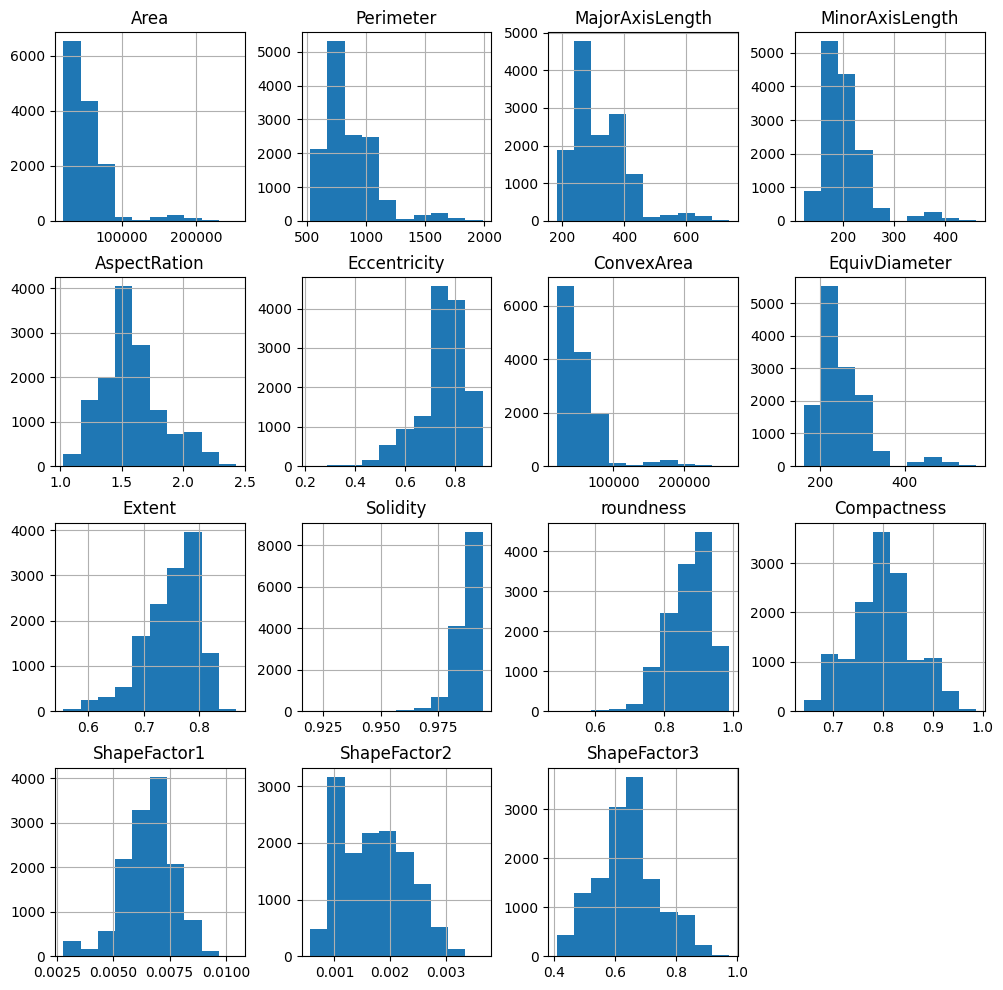

In [4]:
_ = df.iloc[:, :-2].hist(figsize=(12, 12))

### Correlations

From the correlations heatmap below, it can be observed:
1. Some features have very high correlation with other variables (so they are not independent)
2. Some attributes like AspectRation, Extent, ShapeFactor1, ShapeFactor4 have direct correlation to some extent with labels

In [5]:
class_factorized_df = pd.concat([df.iloc[:, :-1], pd.Series(df['Class'].factorize()[0], name='Class')], axis=1)
class_factorized_df.corr().style.background_gradient(cmap='coolwarm')

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
Area,1.000000,0.966722,0.931834,0.951602,0.241735,0.267481,0.999939,0.984968,0.054345,-0.196585,-0.357530,-0.268067,-0.847958,-0.639291,-0.272145,-0.355721,-0.340545
Perimeter,0.966722,1.000000,0.977338,0.913179,0.385276,0.391066,0.967689,0.991380,-0.021160,-0.303970,-0.547647,-0.406857,-0.864623,-0.767592,-0.408435,-0.429310,-0.369302
MajorAxisLength,0.931834,0.977338,1.000000,0.826052,0.550335,0.541972,0.932607,0.961733,-0.078062,-0.284302,-0.596358,-0.568377,-0.773609,-0.859238,-0.568185,-0.482527,-0.257785
MinorAxisLength,0.951602,0.913179,0.826052,1.000000,-0.009161,0.019574,0.951339,0.948539,0.145957,-0.155831,-0.210344,-0.015066,-0.947204,-0.471347,-0.019326,-0.263749,-0.511069
AspectRation,0.241735,0.385276,0.550335,-0.009161,1.000000,0.924293,0.243301,0.303647,-0.370184,-0.267754,-0.766979,-0.987687,0.024593,-0.837841,-0.978592,-0.449264,0.270598
Eccentricity,0.267481,0.391066,0.541972,0.019574,0.924293,1.000000,0.269255,0.318667,-0.319362,-0.297592,-0.722272,-0.970313,0.019920,-0.860141,-0.981058,-0.449354,0.426551
ConvexArea,0.999939,0.967689,0.932607,0.951339,0.243301,0.269255,1.000000,0.985226,0.052564,-0.206191,-0.362083,-0.269922,-0.847950,-0.640862,-0.274024,-0.362049,-0.340615
EquivDiameter,0.984968,0.991380,0.961733,0.948539,0.303647,0.318667,0.985226,1.000000,0.028383,-0.231648,-0.435945,-0.327650,-0.892741,-0.713069,-0.330389,-0.392512,-0.385540
Extent,0.054345,-0.021160,-0.078062,0.145957,-0.370184,-0.319362,0.052564,0.028383,1.000000,0.191389,0.344411,0.354212,-0.141616,0.237956,0.347624,0.148502,-0.137064
Solidity,-0.196585,-0.303970,-0.284302,-0.155831,-0.267754,-0.297592,-0.206191,-0.231648,0.191389,1.000000,0.607150,0.303766,0.153388,0.343559,0.307662,0.702163,0.034980


### Label distribution

From the below bar graph, we can infer following points:
1. There aren't any out-of-place/nullish class values
2. We need to convert the string values of class to numerical representation
3. The class distribution is unbalanced, so the training data needs to be split with stratification.

<Axes: xlabel='Class'>

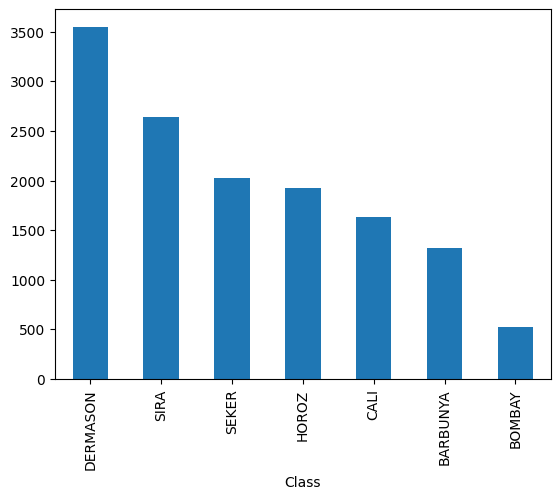

In [6]:
df['Class'].value_counts().plot(kind='bar')

# Data Preprocessing

### Converting string to numerical representation

In [7]:
encoder = LabelEncoder()
df['Class_numerical'] = encoder.fit_transform(df['Class'])

In [8]:
encoder.inverse_transform([0, 1, 2, 3, 4, 6, 5])

array(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SIRA', 'SEKER'],
      dtype=object)

### Normalizing dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-2],
    df["Class_numerical"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df["Class_numerical"],
)

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_features, columns=df.columns[:-2])
X_test = pd.DataFrame(scaler.transform(X_test), columns=df.columns[:-2])
X_train.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,-0.371362,-0.531131,-0.695370,0.086657,-1.293800,-1.515964,-0.380039,-0.361098,0.857421,1.256100,1.516864,1.446832,-0.339818,1.118082,1.485250,0.951416
1,0.028952,0.498818,0.783518,-0.540352,2.401812,1.493455,0.035323,0.150320,-2.941719,-0.843829,-2.378161,-1.999948,0.551406,-1.321497,-1.879534,0.158161
2,0.727078,0.795005,0.824382,0.924849,0.076902,0.330836,0.717120,0.923243,1.203117,0.618792,0.254498,-0.201104,-1.160932,-0.787674,-0.237507,-0.353025
3,0.732131,0.883592,1.020897,0.725643,0.614895,0.721194,0.735383,0.928419,0.870459,-0.479395,-0.253981,-0.715959,-0.969786,-1.032437,-0.732907,-0.973504
4,-0.133509,-0.257497,-0.481242,0.494139,-1.381023,-1.713495,-0.144039,-0.049766,0.713863,1.247235,1.531060,1.569816,-0.786632,0.919368,1.622194,0.910494


As you can see in below histograms, the range of features are normalized

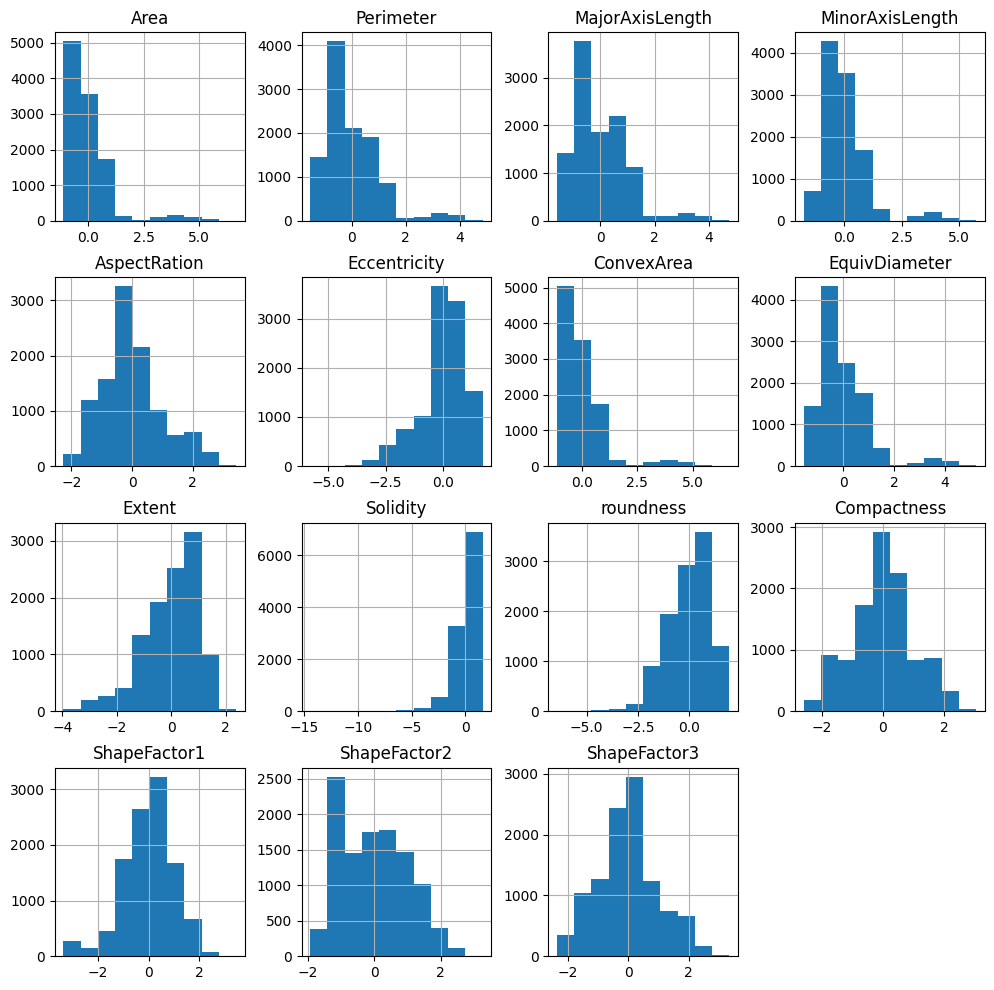

In [11]:
_ = X_train.iloc[:, :-1].hist(figsize=(12, 12))

# Model Training

## Random Forest

In [12]:
params = {
    # "n_estimators": [100, 200, 300],
    # "max_depth": [10, 12],
    "n_estimators": [200],
    "max_depth": [12],
}
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
gridsearch_rf = GridSearchCV(
    RandomForestClassifier(n_jobs=-1),
    params,
    cv=stratified_split,
    n_jobs=-1,
    verbose=1,
)
gridsearch_rf.fit(X_train, y_train)

# Scores
gridsearch_rf.score(X_train, y_train), gridsearch_rf.score(X_test, y_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


(0.9839272593681117, 0.9214102093279471)

In [13]:
# If you uncomment the commented parameters and comment out the current parameters,
# you will get the following output

# gridsearch_rf.best_params_
# Output - {'max_depth': 12, 'n_estimators': 200}

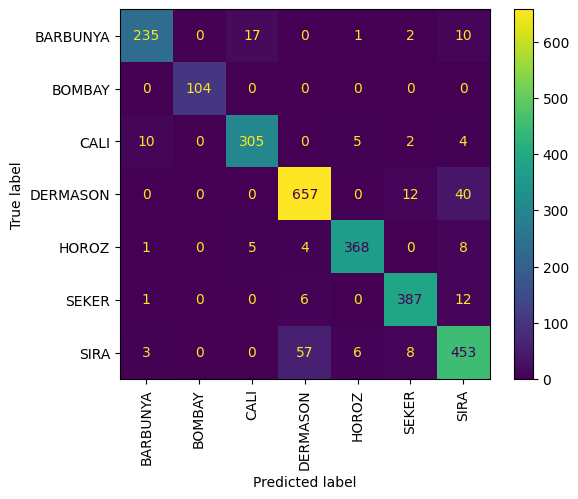

In [14]:
y_pred = gridsearch_rf.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]),
    xticks_rotation="vertical",
)

In [15]:
def f1_score_weighted(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    precision = np.diag(matrix) / matrix.sum(axis=0)
    recall = np.diag(matrix) / matrix.sum(axis=1)
    f1 = 2 * precision * recall / (precision + recall)
    weighted_f1 = np.sum(f1 * matrix.sum(axis=1) / matrix.sum())
    return weighted_f1

In [16]:
f1_score_weighted(y_test, y_pred)

0.9214155306246664

In [17]:
# If you uncomment below code, you will get the following output
# The output is the same as the formula calculation above

# from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average="weighted")

# Output: 0.922548837254795

## Additional Algorithm - SVM

In [18]:
params = {
    # "C": [10, 100, 1000],
    # "kernel": ["linear", "rbf", "sigmoid", "poly"],
    # 'degree': [2, 4, 6]
    "C": [100],
    "kernel": ["rbf"],
    'degree': [2]
    
}
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
gridsearch_svc = GridSearchCV(
    SVC(random_state=42),
    params,
    cv=stratified_split,
    n_jobs=-1,
    verbose=1,
)
gridsearch_svc.fit(X_train, y_train)

# Scores
gridsearch_svc.score(X_train, y_train), gridsearch_svc.score(X_test, y_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


(0.9457200587803086, 0.9250826294528094)

In [19]:
# If you uncomment the commented parameters and comment out the current parameters,
# you will get the following output

# gridsearch_svc.best_params_
# Output - {'C': 100, 'degree': 2, 'kernel': 'rbf'}

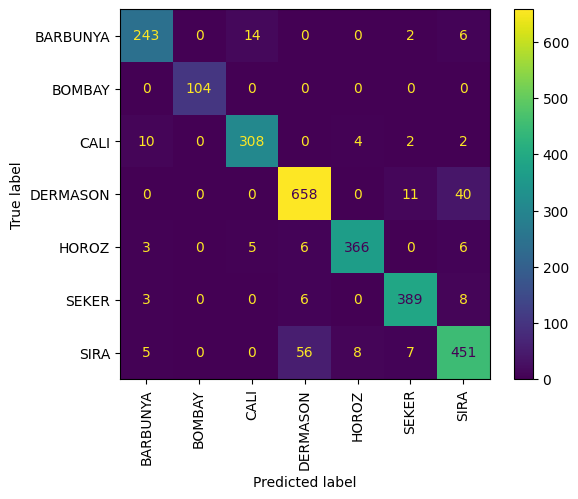

In [20]:
y_pred = gridsearch_svc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]),
    xticks_rotation="vertical",
)

In [21]:
f1_score_weighted(y_test, y_pred)

0.9249781563467131

In [22]:
# If you uncomment below code, you will get the following output
# The output is the same as the formula calculation above

# from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average="weighted")

# Output: 0.924978156346713

## Additional Algorithm - KNN

In [23]:
params = {
    # "n_neighbors": [3, 5, 7],
    # "weights": ["uniform", "distance"],
    # "algorithm": ["ball_tree", "kd_tree", "brute"],
    # "leaf_size": [10, 30, 50],
    # "p": [1, 2, 3],
    "n_neighbors": [7],
    "weights": ["uniform"],
    "algorithm": ["ball_tree"],
    "leaf_size": [10],
    "p": [2],
}
stratified_split = StratifiedShuffleSplit(n_splits=6, test_size=0.1, random_state=42)
gridsearch_svc = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    params,
    cv=stratified_split,
    n_jobs=-1,
    verbose=1,
)
gridsearch_svc.fit(X_train, y_train)

# Scores
gridsearch_svc.score(X_train, y_train), gridsearch_svc.score(X_test, y_test)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


(0.9391991182953711, 0.9136981270657363)

In [24]:
# If you uncomment the commented parameters and comment out the current parameters,
# you will get the following output

# gridsearch_svc.best_params_
# Output - {'algorithm': 'ball_tree',
#  'leaf_size': 10,
#  'n_neighbors': 7,
#  'p': 2,
#  'weights': 'uniform'}

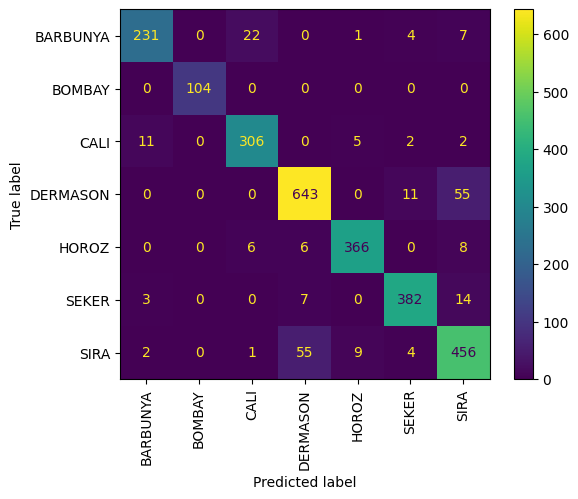

In [25]:
y_pred = gridsearch_svc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]),
    xticks_rotation="vertical",
)

In [26]:
f1_score_weighted(y_test, y_pred)

0.9138644968689182

In [27]:
# If you uncomment below code, you will get the following output
# The output is the same as the formula calculation above

# from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average='weighted')

# Output: 0.9142227933487637

## Additional Deep Learning Algorithm - Conv1D

In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device for torch models")

Using mps device for torch models


In [79]:
class Conv1DNNModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1d_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Flatten(),
            nn.Linear(32 * 10, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 7),
        )

    def forward(self, x):
        return self.conv1d_relu_stack(x)

In [80]:
learning_rate = 1e-1
batch_size = 64
epochs = 50

conv1d_model = Conv1DNNModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(conv1d_model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.45)
summary(conv1d_model, input_size=(batch_size, 1, 16))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DNNModel                            [64, 7]                   --
├─Sequential: 1-1                        [64, 7]                   --
│    └─Conv1d: 2-1                       [64, 128, 14]             512
│    └─ReLU: 2-2                         [64, 128, 14]             --
│    └─BatchNorm1d: 2-3                  [64, 128, 14]             256
│    └─Conv1d: 2-4                       [64, 64, 12]              24,640
│    └─ReLU: 2-5                         [64, 64, 12]              --
│    └─BatchNorm1d: 2-6                  [64, 64, 12]              128
│    └─Conv1d: 2-7                       [64, 32, 10]              6,176
│    └─ReLU: 2-8                         [64, 32, 10]              --
│    └─BatchNorm1d: 2-9                  [64, 32, 10]              64
│    └─Flatten: 2-10                     [64, 320]                 --
│    └─Linear: 2-11                      [64, 64]                  20,544
│

In [81]:
def training_loop(
    train_loader,
    model: nn.Module,
    loss_fn: nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
):
    model.train()
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        pred = model(train_loader.dataset.tensors[0])
        y_train = train_loader.dataset.tensors[1]
        print(
            f"Training metrics\nLoss: {loss.item()}\nF1 Score: {f1_score_weighted(y_train.argmax(dim=1), pred.argmax(dim=1))}"
        )


def test_nn_model(
    test_dataset: TensorDataset, model: nn.Module, loss_fn: nn.CrossEntropyLoss
):
    model.eval()
    with torch.no_grad():
        X_test, y_test = test_dataset.tensors
        pred = model(X_test)
        loss = loss_fn(pred, y_test)

        print(
            f"Test metrics\nLoss: {loss.item()}\nF1 Score: {f1_score_weighted(y_test.argmax(dim=1), pred.argmax(dim=1))}"
        )
        return f1_score_weighted(y_test.argmax(dim=1), pred.argmax(dim=1))

In [82]:
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    max_categories=df["Class_numerical"].value_counts().shape[0],
)
_ = one_hot_encoder.fit(df["Class_numerical"].values.reshape(-1, 1))
y_train_one_hot = one_hot_encoder.transform(y_train.values.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.values.reshape(-1, 1))

In [83]:
train_dataset = TensorDataset(
    torch.tensor(X_train.values.reshape((-1, 1, 16)), dtype=torch.float32),
    torch.tensor(y_train_one_hot, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test.values.reshape((-1, 1, 16)), dtype=torch.float32),
    torch.tensor(y_test_one_hot, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [84]:
best_f1_score = 0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    training_loop(train_loader, conv1d_model, loss_fn, optimizer)
    lr_scheduler.step()
    print()

    test_f1_score = test_nn_model(test_dataset, conv1d_model, loss_fn)
    if (test_f1_score > best_f1_score):
        print("\nFound better model, saving it...")
        best_f1_score = test_f1_score
        torch.save(conv1d_model, "models/best_model.pth")
    
    print()

Epoch 1
-------------------------------
Training metrics
Loss: 0.7865049839019775
F1 Score: 0.9171529604946174

Test metrics
Loss: 0.25620555877685547
F1 Score: 0.9048390811239417

Found better model, saving it...

Epoch 2
-------------------------------
Training metrics
Loss: 0.2460736483335495
F1 Score: 0.9186765556461552

Test metrics
Loss: 0.24679481983184814
F1 Score: 0.9115002723230671

Found better model, saving it...

Epoch 3
-------------------------------
Training metrics
Loss: 0.43649908900260925
F1 Score: 0.9225250795674211

Test metrics
Loss: 0.23689335584640503
F1 Score: 0.9119338411979557

Found better model, saving it...

Epoch 4
-------------------------------
Training metrics
Loss: 0.018556149676442146
F1 Score: 0.9297768416778642

Test metrics
Loss: 0.22743552923202515
F1 Score: 0.9157291910407332

Found better model, saving it...

Epoch 5
-------------------------------
Training metrics
Loss: 0.793008029460907
F1 Score: 0.915075293263306

Test metrics
Loss: 0.264175